我们将建立一个逻辑回归模型来预测一个学生是否被大学录取。假设你是一个大学系的管理员，你想根据两次考试的结果来决定每个申请人的录取机会。你有以前的申请人的历史数据，你可以用它作为逻辑回归的训练集。对于每一个培训例子，你有两个考试的申请人的分数和录取决定。为了做到这一点，我们将建立一个分类模型，根据考试成绩估计入学概率。

In [1]:
#!curl https://code163.blob.core.windows.net/default/LogiReg_data.txt -o LogiReg_data.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3775  100  3775    0     0   3775      0  0:00:01 --:--:--  0:00:01  6138


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
pdData = pd.read_csv('LogiReg_data.txt',header=None,names=['Exam 1','Exam 2','Admitted'])
pdData.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [5]:
pdData.shape

(100, 3)

Text(0,0.5,'Exam 2 Score')

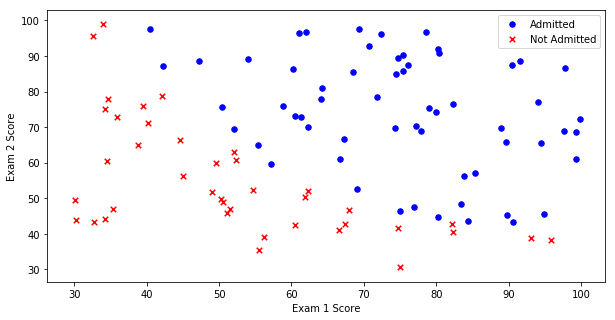

In [6]:
positive = pdData[pdData['Admitted'] == 1]
negative = pdData[pdData['Admitted'] == 0]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=30, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

## The logistic regression

目标：建立分类器（求解出三个参数 $\theta_0         \theta_1         \theta_2 $）


设定阈值，根据阈值判断录取结果

### 要完成的模块
-  `sigmoid` : 映射到概率的函数

-  `model` : 返回预测结果值

-  `cost` : 根据参数计算损失

-  `gradient` : 计算每个参数的梯度方向

-  `descent` : 进行参数更新

-  `accuracy`: 计算精度

###  `sigmoid` 函数

$$
g(z) = \frac{1}{1+e^{-z}}   
$$

In [57]:
def sigmoid(z):
    return 1/(1+ np.exp(-z))

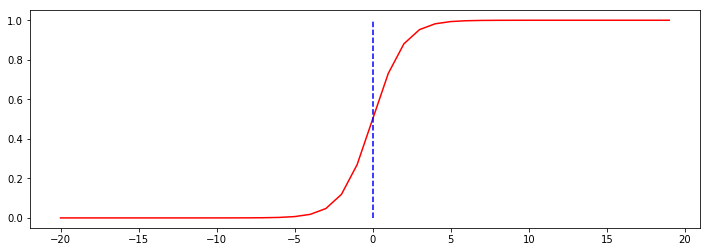

In [16]:
nums = np.arange(-20, 20, step=1) #creates a vector containing 20 equally spaced values from -10 to 10
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(nums, sigmoid(nums), 'r')
ax.plot([0,0],[0,1], 'b--')

### Sigmoid
* $g:\mathbb{R} \to [0,1]$
* $g(0)=0.5$
* $g(- \infty)=0$
* $g(+ \infty)=1$

In [58]:
pdData.insert(0,'ones',1) # insert a column named 'ones' with value = 1
matrix_data = pdData.as_matrix()
theta = np.zeros([1,3]) # 1 row, 3 cols

In [95]:
num_of_cols = matrix_data.shape[1]
X = matrix_data[:,0:num_of_cols-1]
y = matrix_data[:,num_of_cols-1:num_of_cols]


In [93]:
print(X[:5])
print(y[:5])
print(theta)

[[  1.          74.78925296  41.57341523]
 [  1.          62.0730638   96.76882412]
 [  1.          90.54671411  43.39060181]
 [  1.          66.74671857  60.99139403]
 [  1.          75.39561147  85.75993667]]
[[ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
[[ 0.  0.  0.]]


$$
\begin{array}{ccc}
\begin{pmatrix}\theta_{0} & \theta_{1} & \theta_{2}\end{pmatrix} & \times & \begin{pmatrix}1\\
x_{1}\\
x_{2}
\end{pmatrix}\end{array}=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}
$$

In [59]:
def model(X, theta):
    #return np.dot(X,theta.T)
    return sigmoid(np.dot(X,theta.T))

In [6]:
# X = np.matrix([[1,2,3],[2,3,4]])
# theta = np.matrix([1,2,3])
# model(X,theta)

matrix([[ 0.99999917],
        [ 1.        ]])

### 预测值与误差:
$$
y_i = \theta^Tx_i + \epsilon_i
$$
** 由于误差服从高斯分布: **
$$
p(\epsilon_i) = \frac{1}{\sqrt{2\pi}\delta}\exp(-\frac{\epsilon_i^2}{2\delta^2})
$$
So that:
$$
p(y_i|x_i;\theta) = \frac{1}{\sqrt{2\pi}\delta}\exp(-\frac{(y_i-\theta^Tx_i)^2}{2\delta^2})
$$

** 似然函数：** (考点）
$$
L(\theta) = \prod_{i=1}^{n}p(y_i|x_i;\theta) = \prod_{i=1}^{n}\frac{1}{\sqrt{2\pi}\delta}\exp(-\frac{(y_{i}-\theta^Tx_{i})^2}{2\delta^2})
$$
解释：什么样的参数和数据组合后恰好是真实值，求最大似然函数，就是求可能性最大的函数

** 对数似然：**(考点）
$$
\log L(\theta) = \log \prod_{i=1}^{n}\frac{1}{\sqrt{2\pi}\delta}\exp(-\frac{(y_{i}-\theta^Tx_{i})^2}{2\delta^2})
$$
解释：乘法难解，加法就容易了，对数里面乘法可以转换成加法

展开化简
$$
\log L(\theta) = m\log \frac{1}{\sqrt{2\pi}\delta} - \frac{1}{\delta^2}\times\frac{1}{2}\sum_{i=1}^{m}(y_{i}-\theta^Tx_{i})^2
$$
目标：让似然函数（对数变换后也一样）越大越好

**(考点）所以下面的值越小越好**
$$
J(\theta)=\frac{1}{2}\sum_{i=1}^{m} (y_{i}-\theta^Tx_{i})^2 = \frac{1}{2}\sum_{i=1}^{m} (h_\theta(x_i)-y_i)^2 = \frac{1}{2}(X\theta - y)^T(X\theta - y)
$$
(最小二乘法)
偏导等于0:
$$
\theta = (X^TX)^{-1}X^Ty
$$

** 但通常我们不通过这种直接求导的方式来算θ，而是用梯度下降的方式，来求近似解 **
### 梯度下降
* 引入：当我们得到了一个目标函数后，如何进行求解？直接求解？（并不一定可解，线性回归可以当做是一个特例）
* 常规套路：机器学习的套路就是我交给机器一堆数据，然后告诉它什么样的学习方式是对的（目标函数），然后让它朝着这个方向去做
* 如何优化：一口吃不成个胖子，我们要静悄悄的一步步的完成迭代（每次优化一点点，累积起来就是个大成绩了）
* 寻找山谷的最低点，也就是我们的目标函数终点（什么样的参数能使得目标函数达到极值点）



### 计算梯度


$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$

In [60]:
def gradient(X, y ,theta):
    grad = np.zeros(theta.shape)
    error = (model(X,theta) - y).ravel()
    for j in range(len(theta.ravel())):
        term = np.multiply(error, X[:,j])
        grad[0,j] = np.sum(term) / len(X)
    
    return grad

In [11]:
# X = np.matrix([[1,2,3],[2,3,4]])
# theta = np.matrix([1,2,3])
# y = [2,4]
# t = gradient(X,y,theta)
# print(t)

[[-12.0000025 -12.0000025 -12.0000025]]


### 损失函数
将对数似然函数去负号

$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$$
求平均损失
$$
J(\theta)=\frac{1}{n}\sum_{i=1}^{n} D(h_\theta(x_i), y_i)
$$

In [61]:
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X,theta)))
    right = np.multiply(1 - y,np.log(1 - model(X,theta)))
    return np.sum(left - right)/(len(X))

In [40]:
t= cost(X,y,theta)
print(t)

0.69314718056


比较3中不同梯度下降方法

In [51]:
a = np.matrix([1,2,3])
print(np.linalg.norm(a))

3.74165738677


In [63]:
t = np.dot(a,a.T)

In [62]:
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    if type == STOP_ITER:
        return value > threshold
    elif type == STOP_COST:
        return abs(value[-1] - value[-2]) < threshold
    elif type == STOP_GRAD:
        return np.linalg.norm(value) < threshold

In [63]:
import numpy.random

def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:,0:cols-1]
    y = data[:,cols-1:]
    return X,y

In [29]:
# import time

# def descent(data, theta, batchSize, stopType, thresh, alpha):
#     #梯度下降求解
    
#     init_time = time.time()
#     iterCnt = 0 # 迭代次数
#     currentSize = 0 # batch
#     X, y = shuffleData(data)
#     grad = np.zeros(theta.shape) # 计算的梯度
#     costs = [cost(X, y, theta)] # 损失值

    
#     while True:
#         grad = gradient(X[currentSize:currentSize+batchSize],    \
#                         y[currentSize:currentSize+batchSize],    \
#                         theta)
#         currentSize += batchSize #取batch数量个数据
#         if currentSize >= n: 
#             currentSize = 0 
#             #X, y = shuffleData(data) #重新洗牌
            
#         theta = theta - alpha*grad # 参数更新
#         costs.append(cost(X, y, theta)) # 计算新的损失
#         iterCnt += 1 

#         if stopType == STOP_ITER:       value = iterCnt
#         elif stopType == STOP_COST:     value = costs
#         elif stopType == STOP_GRAD:     value = grad
#         if stopCriterion(stopType, value, thresh): break
    
#     return theta, iterCnt-1, costs, grad, time.time() - init_time

In [64]:
import time

#梯度下降求解
def descent(data, theta, batchSize,stopType, thresh, alpha):
    init_time = time.time()
    iterCnt = 0
    currentSize = 0
    X,y = shuffleData(data)
    grad = np.zeros(theta.shape)
    costs = [cost(X,y,theta)]
    
    while True:
        grad = gradient(X[currentSize:currentSize+batchSize],   \
                        y[currentSize:currentSize+batchSize],   \
                        theta)
        currentSize += batchSize
        
        if currentSize >= n:
            currentSize = 0
        
        theta = theta - alpha * grad
        costs.append(cost(X,y,theta))
        iterCnt += 1
        
        if stopType == STOP_ITER:
            value = iterCnt
        elif stopType == STOP_COST:
            value = costs
        elif stopType == STOP_GRAD:
            value = grad
        
        if stopCriterion(stopType, value, thresh):
            break
    
    return theta, iterCnt - 1, costs, grad, time.time() - init_time
            

In [65]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

### 不同的停止策略
#### 设定迭代次数

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 0.49s


array([[-0.00027127,  0.00705232,  0.00376711]])

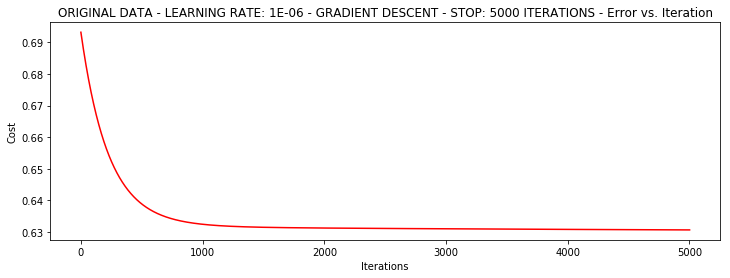

In [66]:
#选择的梯度下降方法是基于所有样本的
n=100
runExpe(matrix_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

#### 根据损失值停止
设定阈值 1E-6, 差不多需要110 000次迭代 

***Original data - learning rate: 0.001 - Gradient descent - Stop: costs change < 1e-06
Theta: [[-5.13364014  0.04771429  0.04072397]] - Iter: 109901 - Last cost: 0.38 - Duration: 11.94s


array([[-5.13364014,  0.04771429,  0.04072397]])

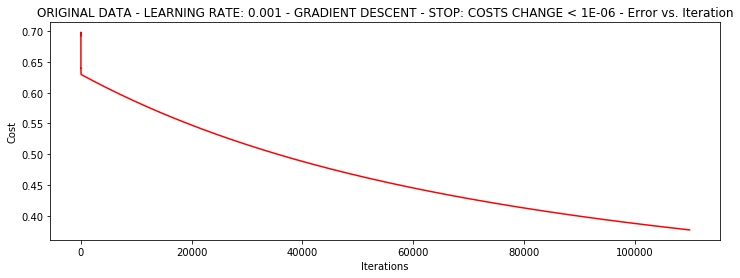

In [35]:
runExpe(matrix_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

#### 根据梯度变化停止
设定阈值 0.05,差不多需要40 000次迭代

***Original data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.05
Theta: [[-2.37033409  0.02721692  0.01899456]] - Iter: 40045 - Last cost: 0.49 - Duration: 4.54s


array([[-2.37033409,  0.02721692,  0.01899456]])

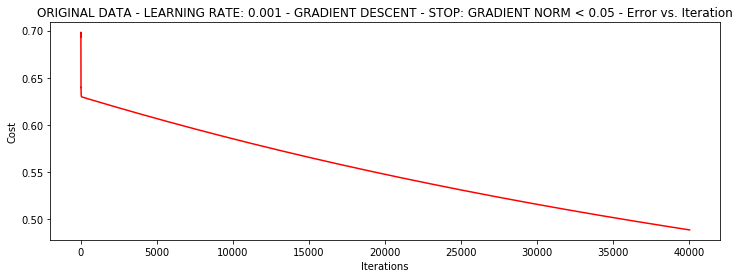

In [37]:
runExpe(matrix_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)

### 对比不同的梯度下降方法
Stochastic descent

***Original data - learning rate: 0.001 - Stochastic descent - Stop: 5000 iterations
Theta: [[-0.37895511  0.13339472 -0.01672218]] - Iter: 5000 - Last cost: 2.27 - Duration: 0.47s


array([[-0.37895511,  0.13339472, -0.01672218]])

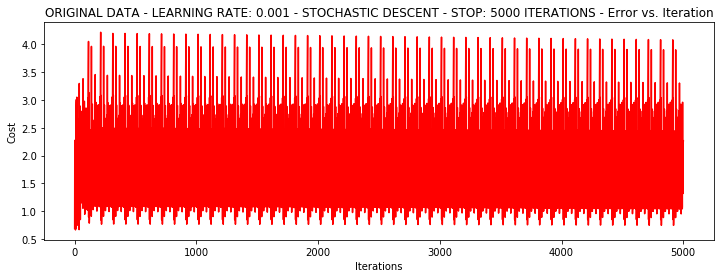

In [40]:
runExpe(matrix_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

试试把学习率调小一些

***Original data - learning rate: 2e-06 - Stochastic descent - Stop: 15000 iterations
Theta: [[-0.00201997  0.01006794  0.00118191]] - Iter: 15000 - Last cost: 0.63 - Duration: 1.44s


array([[-0.00201997,  0.01006794,  0.00118191]])

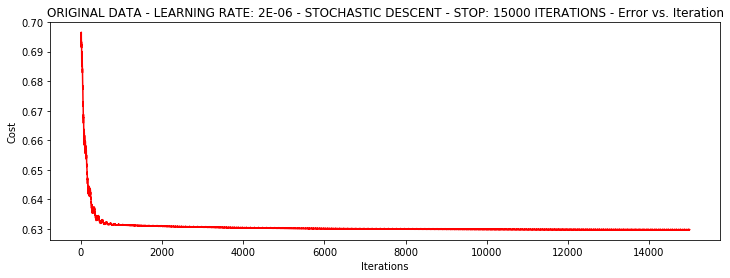

In [42]:
runExpe(matrix_data, theta, 1, STOP_ITER, thresh=15000, alpha=0.000002)

速度快，但稳定性差，需要很小的学习率
#### Mini-batch descent

***Original data - learning rate: 0.001 - Mini-batch (16) descent - Stop: 15000 iterations
Theta: [[-1.03359856  0.02816707 -0.04050869]] - Iter: 15000 - Last cost: 1.35 - Duration: 1.40s


array([[-1.03359856,  0.02816707, -0.04050869]])

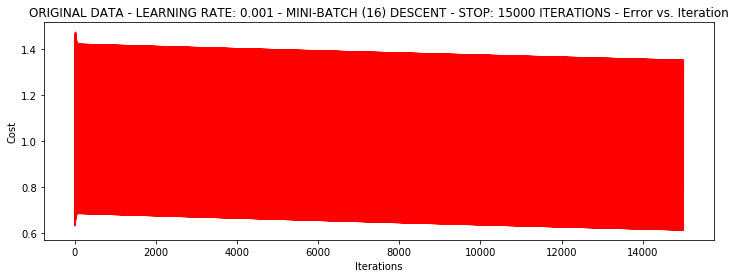

In [44]:
runExpe(matrix_data, theta, 16, STOP_ITER, thresh=15000, alpha=0.001)

浮动仍然比较大，我们来尝试下对数据进行标准化 将数据按其属性(按列进行)减去其均值，然后除以其方差。最后得到的结果是，对每个属性/每列来说所有数据都聚集在0附近，方差值为1

In [50]:
from sklearn import preprocessing as pp

scaled_data = matrix_data.copy()
print(scaled_data[:5,:])
# 只对 1：3 列操作
scaled_data[:, 1:3] = pp.scale(matrix_data[:, 1:3])
print(scaled_data[:5,:])

[[  1.          33.91550011  98.86943574   0.        ]
 [  1.          42.26170081  87.10385094   1.        ]
 [  1.          88.91389642  69.8037889    1.        ]
 [  1.          75.02474557  46.55401354   1.        ]
 [  1.          60.45788574  73.0949981    1.        ]]
[[ 1.         -1.63882482  1.76571557  0.        ]
 [ 1.         -1.2077347   1.12938152  1.        ]
 [ 1.          1.20190067  0.19371884  1.        ]
 [ 1.          0.4845113  -1.06373024  1.        ]
 [ 1.         -0.26788246  0.37172177  1.        ]]


***Scaled data - learning rate: 0.001 - Gradient descent - Stop: 5000 iterations
Theta: [[ 0.3080807   0.86494967  0.77367651]] - Iter: 5000 - Last cost: 0.38 - Duration: 0.64s


array([[ 0.3080807 ,  0.86494967,  0.77367651]])

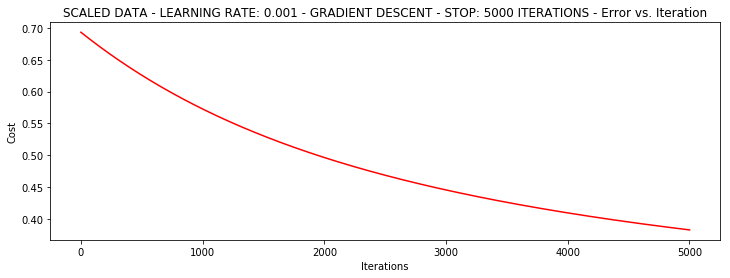

In [51]:
runExpe(scaled_data, theta, n, STOP_ITER, thresh=5000, alpha=0.001)

它好多了！原始数据，只能达到达到0.61，而我们得到了0.38个在这里！ 所以对数据做预处理是非常重要的

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.02
Theta: [[ 1.0707921   2.63030842  2.41079787]] - Iter: 59422 - Last cost: 0.22 - Duration: 8.49s


array([[ 1.0707921 ,  2.63030842,  2.41079787]])

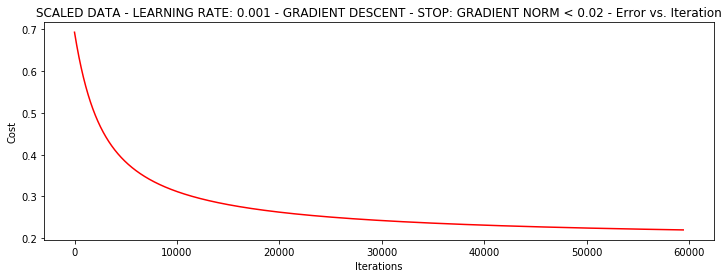

In [52]:
runExpe(scaled_data, theta, n, STOP_GRAD, thresh=0.02, alpha=0.001)

更多的迭代次数会使得损失下降的更多

***Scaled data - learning rate: 0.001 - Stochastic descent - Stop: gradient norm < 0.0004
Theta: [[ 1.14882513  2.79153502  2.56679439]] - Iter: 72564 - Last cost: 0.22 - Duration: 8.69s


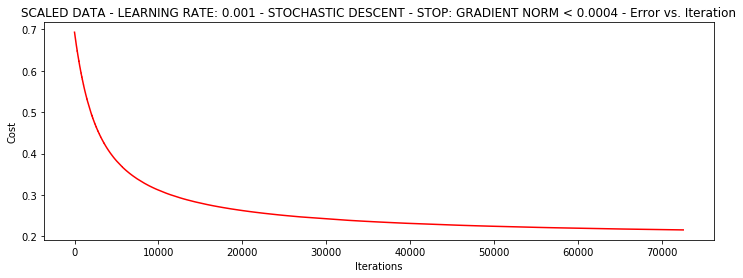

In [67]:
theta = runExpe(scaled_data, theta, 1, STOP_GRAD, thresh=0.002/5, alpha=0.001)

随机梯度下降更快，但是我们需要迭代的次数也需要更多，所以还是用batch的比较合适！！！

In [68]:
runExpe(scaled_data, theta, 16, STOP_GRAD, thresh=0.002*2, alpha=0.001)

KeyboardInterrupt: 

## 精度

In [69]:
theta

array([[ 1.14882513,  2.79153502,  2.56679439]])

In [70]:
#设定阈值
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [77]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (np.sum(correct)) / len(correct)
print ('accuracy = {0}'.format(accuracy))


accuracy = 0.89
